In [24]:
import numpy as np
import torch
import copy
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler


In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [37]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.RandomResizedCrop(150),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets

train_dir = 'balanced_data/buildings_no_buildings/train'
test_dir = 'balanced_data/buildings_no_buildings/test'


train_set = datasets.ImageFolder(train_dir, transform=transform)
test_set = datasets.ImageFolder(test_dir, transform=transform)


# obtain training indices that will be used for validation
num_train = len(train_set)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)




# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = train_set.classes

In [39]:
import torch.nn as nn
import torch.nn.functional as F




# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 150x150x3 image tensor)112,56,28
        self.conv1 = nn.Conv2d(3, 16, 3)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 128, 3)
        

        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (7 * 7 * 128 -> 1024)
        self.fc1 = nn.Linear(128 * 7 * 7, 180)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(180, 100)
        self.fc3 = nn.Linear(100, 50)
        self.fc4 = nn.Linear(50, 2)
       
        # dropout layer (p=0.5)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        

        # flatten image input
        x = x.view(-1, 128 * 7 * 7)
        # add dropout layer
       
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))

        # add 2nd hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        
        x = F.relu(self.fc3(x))
         # add dropout layer
        x = self.dropout(x)
        
        x = self.fc4(x)
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
model.to('cuda')

import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=5e-4)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6272, out_features=180, bias=True)
  (fc2): Linear(in_features=180, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=2, bias=True)
  (dropout): Dropout(p=0.5)
)


In [33]:
model = Net()

optimizer = optim.Adam(model.parameters(), lr=5e-4)

In [40]:
train_on_gpu = True
model.cuda()
# number of epochs to train the model
n_epochs = 60

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    total = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
    
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        # update the total count for labels
        total += target.size(0)
        _, predicted = torch.max(output.data, 1)
        correct += (predicted == target).sum().item()
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    valid_acc = correct / total
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tValidation Acc: {:.6f}'.format(
        epoch, train_loss, valid_loss, valid_acc))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'traditioanl_model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.547222 	Validation Loss: 0.131339 	Validation Acc: 0.589988
Validation loss decreased (inf --> 0.131339).  Saving model ...
Epoch: 2 	Training Loss: 0.497650 	Validation Loss: 0.135486 	Validation Acc: 0.660310
Epoch: 3 	Training Loss: 0.459311 	Validation Loss: 0.109461 	Validation Acc: 0.733015
Validation loss decreased (0.131339 --> 0.109461).  Saving model ...
Epoch: 4 	Training Loss: 0.417223 	Validation Loss: 0.095455 	Validation Acc: 0.783075
Validation loss decreased (0.109461 --> 0.095455).  Saving model ...
Epoch: 5 	Training Loss: 0.394164 	Validation Loss: 0.095229 	Validation Acc: 0.786651
Validation loss decreased (0.095455 --> 0.095229).  Saving model ...
Epoch: 6 	Training Loss: 0.388772 	Validation Loss: 0.088386 	Validation Acc: 0.804529
Validation loss decreased (0.095229 --> 0.088386).  Saving model ...
Epoch: 7 	Training Loss: 0.361785 	Validation Loss: 0.089234 	Validation Acc: 0.806913
Epoch: 8 	Training Loss: 0.359273 	Validation Loss:

In [44]:
model.load_state_dict(torch.load('traditional_model.pt'))

FileNotFoundError: [Errno 2] No such file or directory: 'traditional_model.pt'

In [45]:
print('BInary result: /n')
train_on_gpu = True
model.cuda()
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))
save = []
model.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model

    output = model(data)
    
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(len(data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(train_set.classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

BInary result: /n
Test Loss: 0.268784

Test Accuracy of buildings: 92% (406/437)
Test Accuracy of no_buildings: 88% (2257/2563)

Test Accuracy (Overall): 88% (2663/3000)


In [36]:
train_on_gpu = True
model.cuda()
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))
save = []
model.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model

    output = model(data)
    
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(len(data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(6):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.492669

Test Accuracy of buildings: 83% (367/437)
Test Accuracy of forest: 94% (449/474)
Test Accuracy of glacier: 77% (430/553)
Test Accuracy of mountain: 73% (386/525)
Test Accuracy of   sea: 86% (442/510)
Test Accuracy of street: 81% (406/501)

Test Accuracy (Overall): 82% (2480/3000)


In [39]:
sm = torch.nn.Softmax()
output = model(data)
st = sm(output)

/home/bz15/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


In [61]:
six = torch.zeros([24, 6], dtype=torch.float32)
st[:,0]
six.size()

torch.Size([24, 6])

In [64]:
for i in range(5):
    six[:,i] = st[:,0]
six[:,5] = st[:,1]

In [66]:
torch.max(six, 1)

(tensor([0.9449, 0.9100, 0.8512, 0.6714, 0.7088, 0.8418, 0.8985, 0.8987, 0.7162,
         0.8965, 0.9323, 0.8025, 0.9166, 0.7486, 0.8542, 0.9518, 0.7608, 0.9124,
         0.6842, 0.5589, 0.7164, 0.9650, 0.6083, 0.8151],
        grad_fn=<MaxBackward0>),
 tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 4, 5, 5]))

In [93]:
building = Net()
forest = Net()
glacier = Net()
moutain = Net()
sea = Net()
street = Net()

In [94]:
building.load_state_dict(torch.load('building_model_balance.pt'))
forest.load_state_dict(torch.load('forest_model_balance.pt'))
glacier.load_state_dict(torch.load('glacier_model_balance.pt'))
moutain.load_state_dict(torch.load('moutain_model_balance.pt'))
sea.load_state_dict(torch.load('sea_model_balance_second_score_is_object.pt'))
street.load_state_dict(torch.load('street_model_balance.pt'))

In [98]:
models = list([building, forest, glacier, moutain, sea, street])
models


[Net(
   (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
   (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
   (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
   (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
   (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (fc1): Linear(in_features=6272, out_features=180, bias=True)
   (fc2): Linear(in_features=180, out_features=100, bias=True)
   (fc3): Linear(in_features=100, out_features=50, bias=True)
   (fc4): Linear(in_features=50, out_features=2, bias=True)
   (dropout): Dropout(p=0.5)
 ), Net(
   (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
   (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
   (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
   (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
   (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (fc1): Linear(in_features=6272, out_

In [106]:
classes = test_set.classes

In [136]:
train_on_gpu = True
for model in models:
    model.cuda()
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))
save = []
for model in models:
    model.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    size = len(data)
    class_num = len(test_set.classes)
    output = torch.zeros([size, class_num], dtype=torch.float32)
    
    # get the prediction from each model, only take the first value for first 4 models
    for i in range(4):
        temp = sm(models[i](data))
        output[:,i] = temp[:,0]
        
    
    # only take the second prediction value from model 5 and 6(because sea and no_sea is different alphabtical order)
    for i in range(4, 6):
        temp = sm(models[i](data))
        output[:,i] = temp[:,1]

    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    pred = pred.cuda()
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(len(data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(6):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

/home/bz15/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/bz15/.local/lib/python3.5/site-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Test Loss: 0.000000

Test Accuracy of buildings: 71% (314/437)
Test Accuracy of forest: 82% (389/474)
Test Accuracy of glacier: 61% (342/553)
Test Accuracy of mountain: 60% (316/525)
Test Accuracy of   sea: 60% (310/510)
Test Accuracy of street: 63% (316/501)

Test Accuracy (Overall): 66% (1987/3000)


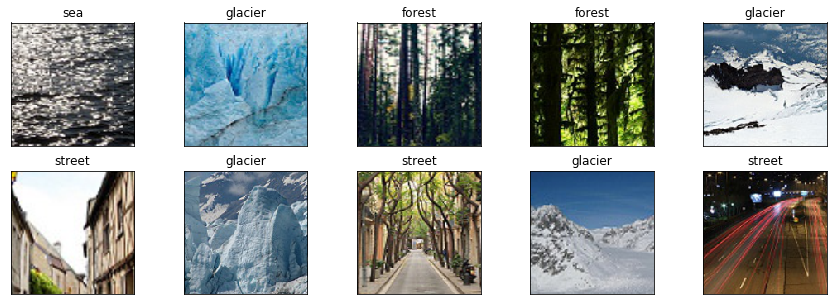

In [22]:
# visualize the train_set
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()



images = images.numpy() # convert images to numpy for display
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(15, 5))
# display 20 images
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    
    imshow(images[idx])
    ax.set_title("{}".format(classes[labels[idx]]))

/home/bz15/.local/lib/python3.5/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/bz15/.local/lib/python3.5/site-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


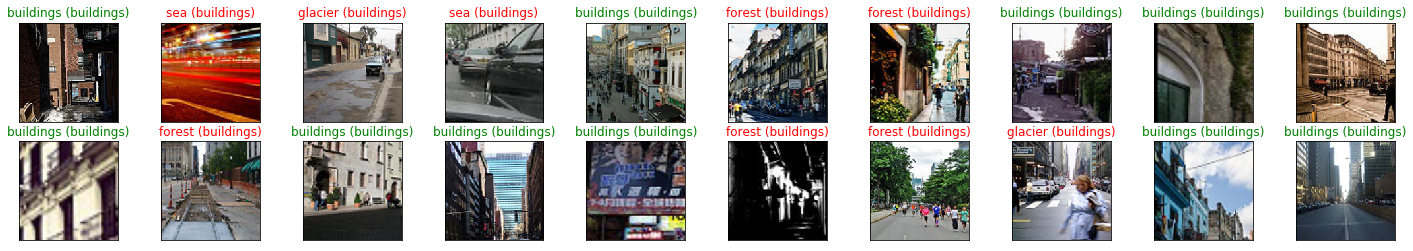

In [129]:

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = data.cpu()
images.numpy()


output_check = []
for model in models:
    model.cpu()

# get sample outputs
output = torch.zeros([size, class_num], dtype=torch.float32)
    
# get the prediction from each model, only take the first value for first 4 models
for i in range(4):
    temp = sm(models[i](images))
    output[:,i] = temp[:,0]
        

# only take the second prediction value from model 5 and 6(because sea and no_sea is different alphabtical order)

temp = sm(models[4](images))
output[:,4] = temp[:,1]
output
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

images.cpu()
# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

In [118]:
output

tensor([[5.0339e-01, 3.1371e-01, 6.2978e-02, 5.6529e-02, 4.8112e-02, 9.2479e-01],
        [6.0223e-01, 6.1464e-02, 4.3679e-02, 8.2832e-02, 8.3589e-01, 9.2189e-01],
        [1.6614e-01, 1.4973e-01, 4.2065e-01, 1.4643e-01, 1.8153e-01, 8.4185e-01],
        [2.4771e-01, 4.1152e-01, 2.8637e-01, 1.8306e-01, 4.8981e-01, 6.6800e-01],
        [6.9748e-01, 6.3448e-01, 1.5078e-01, 1.5936e-01, 8.5051e-02, 6.5399e-01],
        [4.3994e-01, 4.7804e-01, 1.0598e-01, 1.2534e-01, 4.9433e-02, 7.9217e-01],
        [3.2962e-01, 5.1111e-01, 9.7475e-02, 9.6621e-02, 4.2653e-02, 9.0397e-01],
        [7.5752e-01, 8.2596e-02, 1.8701e-01, 3.5342e-01, 2.1410e-01, 8.8677e-01],
        [7.3419e-01, 6.0551e-01, 2.6632e-01, 1.6944e-01, 1.8266e-01, 7.2763e-01],
        [9.1272e-01, 6.7281e-02, 7.3846e-02, 1.0654e-01, 1.8268e-01, 9.1035e-01],
        [6.8112e-01, 1.5983e-01, 3.4549e-01, 1.0791e-01, 1.4805e-01, 9.1766e-01],
        [9.8418e-02, 4.8343e-01, 3.0259e-01, 1.7027e-01, 1.6785e-01, 7.6462e-01],
        [6.6363e

In [127]:
sm(models[5](images))

/home/bz15/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([[0.0752, 0.9248],
        [0.0781, 0.9219],
        [0.1581, 0.8419],
        [0.3320, 0.6680],
        [0.3460, 0.6540],
        [0.2078, 0.7922],
        [0.0960, 0.9040],
        [0.1132, 0.8868],
        [0.2724, 0.7276],
        [0.0897, 0.9103],
        [0.0823, 0.9177],
        [0.2354, 0.7646],
        [0.0882, 0.9118],
        [0.1385, 0.8615],
        [0.2560, 0.7440],
        [0.0616, 0.9384],
        [0.1809, 0.8191],
        [0.0809, 0.9191],
        [0.4093, 0.5907],
        [0.2065, 0.7935],
        [0.0857, 0.9143],
        [0.9431, 0.0569],
        [0.1711, 0.8289],
        [0.1455, 0.8545]], grad_fn=<SoftmaxBackward>)

In [ ]:
0.5034 buijlding
0.31371 forest
0.06 glacier
0.05 moutain
0.9 sea
0.07 street

In [13]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
model.cpu()
y = model(images)

In [1]:
import os

os.environ['KERAS_BACKEND'] = 'tensorflow'

In [3]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

Using TensorFlow backend.


NameError: name 'model' is not defined

In [3]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')